In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from transformers import TrainerCallback

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-06-02 13:49:56.367695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train = pd.read_csv("data/cooked_dataset_train.csv", encoding='utf-8', index_col='Unnamed: 0')  
valid = pd.read_csv("data/cooked_dataset_valid.csv", encoding='utf-8', index_col='Unnamed: 0')
test =  pd.read_csv("data/cooked_dataset_test.csv", encoding='utf-8', index_col='Unnamed: 0')
#train, remaining = train_test_split(df, test_size=0.3, random_state=42)
#valid, test = train_test_split(df, test_size=0.5, random_state=42)

In [5]:
train_texts = train['clean_text'].tolist()
train_labels = train['generated'].tolist()

valid_texts = valid['clean_text'].tolist()
valid_labels = valid['generated'].tolist()

test_texts = test['clean_text'].tolist()  
test_labels = test['generated'].tolist() 

tokenizer = RobertaTokenizer.from_pretrained("blinoff/roberta-base-russian-v0")


train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
valid_dataset = CustomDataset(valid_encodings, valid_labels)
test_dataset = CustomDataset(test_encodings, test_labels)



/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = RobertaForSequenceClassification.from_pretrained("blinoff/roberta-base-russian-v0", num_labels=2).to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at blinoff/roberta-base-russian-v0 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
training_args = TrainingArguments(
    output_dir="../temp/results",  
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    logging_dir="../temp/logs",
    logging_steps=200,  
    save_total_limit=1,  
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)
trainer.train()


  4%|▍         | 200/5170 [03:08<1:17:31,  1.07it/s]

{'loss': 0.4016, 'grad_norm': 20.402978897094727, 'learning_rate': 4.8065764023210835e-05, 'epoch': 0.19}


  8%|▊         | 400/5170 [06:15<1:14:22,  1.07it/s]

{'loss': 0.2117, 'grad_norm': 0.4632537066936493, 'learning_rate': 4.613152804642167e-05, 'epoch': 0.39}


 12%|█▏        | 600/5170 [09:35<1:11:16,  1.07it/s]

{'loss': 0.1258, 'grad_norm': 14.01109504699707, 'learning_rate': 4.4197292069632494e-05, 'epoch': 0.58}


 15%|█▌        | 800/5170 [12:42<1:08:09,  1.07it/s]

{'loss': 0.1207, 'grad_norm': 11.559666633605957, 'learning_rate': 4.226305609284333e-05, 'epoch': 0.77}


 19%|█▉        | 1000/5170 [15:49<1:05:01,  1.07it/s]

{'loss': 0.0987, 'grad_norm': 28.221887588500977, 'learning_rate': 4.032882011605416e-05, 'epoch': 0.97}


100%|█████████▉| 221/222 [01:07<00:00,  3.28it/s]
                                                     
100%|██████████| 222/222 [01:07<00:00,  3.29it/s]
                                                 

{'eval_loss': 0.10072652250528336, 'eval_runtime': 67.8961, 'eval_samples_per_second': 104.409, 'eval_steps_per_second': 3.27, 'epoch': 1.0}


 23%|██▎       | 1200/5170 [20:17<1:01:54,  1.07it/s] 

{'loss': 0.0589, 'grad_norm': 32.018619537353516, 'learning_rate': 3.839458413926499e-05, 'epoch': 1.16}


 27%|██▋       | 1400/5170 [23:25<58:50,  1.07it/s]  

{'loss': 0.0715, 'grad_norm': 32.30922317504883, 'learning_rate': 3.646034816247582e-05, 'epoch': 1.35}


 31%|███       | 1600/5170 [26:47<55:42,  1.07it/s]  

{'loss': 0.035, 'grad_norm': 0.6784606575965881, 'learning_rate': 3.452611218568665e-05, 'epoch': 1.55}


 35%|███▍      | 1800/5170 [29:54<52:36,  1.07it/s]

{'loss': 0.0392, 'grad_norm': 2.494755506515503, 'learning_rate': 3.2591876208897484e-05, 'epoch': 1.74}


 39%|███▊      | 2000/5170 [33:01<49:29,  1.07it/s]

{'loss': 0.0401, 'grad_norm': 0.01534461323171854, 'learning_rate': 3.065764023210832e-05, 'epoch': 1.93}


100%|█████████▉| 221/222 [01:07<00:00,  3.28it/s]
                                                   A
100%|██████████| 222/222 [01:07<00:00,  3.29it/s]
                                                 

{'eval_loss': 0.05831122770905495, 'eval_runtime': 67.8821, 'eval_samples_per_second': 104.431, 'eval_steps_per_second': 3.27, 'epoch': 2.0}


 43%|████▎     | 2200/5170 [37:29<46:20,  1.07it/s]   

{'loss': 0.0271, 'grad_norm': 0.6733056902885437, 'learning_rate': 2.8723404255319154e-05, 'epoch': 2.13}


 46%|████▋     | 2400/5170 [40:37<43:13,  1.07it/s]

{'loss': 0.0189, 'grad_norm': 0.013895900920033455, 'learning_rate': 2.678916827852998e-05, 'epoch': 2.32}


 50%|█████     | 2600/5170 [44:01<40:04,  1.07it/s]  

{'loss': 0.0151, 'grad_norm': 0.0334012508392334, 'learning_rate': 2.4854932301740812e-05, 'epoch': 2.51}


 54%|█████▍    | 2800/5170 [47:08<36:57,  1.07it/s]

{'loss': 0.012, 'grad_norm': 0.0034482309129089117, 'learning_rate': 2.2920696324951645e-05, 'epoch': 2.71}


 58%|█████▊    | 3000/5170 [50:15<33:51,  1.07it/s]

{'loss': 0.0181, 'grad_norm': 0.0037233990151435137, 'learning_rate': 2.0986460348162475e-05, 'epoch': 2.9}


IOStream.flush timed out
100%|█████████▉| 221/222 [01:07<00:00,  3.27it/s]
                                                   A
100%|██████████| 222/222 [01:07<00:00,  3.29it/s]
                                                 

{'eval_loss': 0.06770305335521698, 'eval_runtime': 67.887, 'eval_samples_per_second': 104.424, 'eval_steps_per_second': 3.27, 'epoch': 3.0}


 62%|██████▏   | 3200/5170 [54:47<30:44,  1.07it/s]   

{'loss': 0.0142, 'grad_norm': 0.008323343470692635, 'learning_rate': 1.9052224371373308e-05, 'epoch': 3.09}


 66%|██████▌   | 3400/5170 [57:54<27:35,  1.07it/s]

{'loss': 0.0028, 'grad_norm': 0.013089685700833797, 'learning_rate': 1.711798839458414e-05, 'epoch': 3.29}


 70%|██████▉   | 3600/5170 [1:01:18<24:30,  1.07it/s]

{'loss': 0.0047, 'grad_norm': 0.0019714487716555595, 'learning_rate': 1.5183752417794972e-05, 'epoch': 3.48}


 74%|███████▎  | 3800/5170 [1:04:25<21:24,  1.07it/s]

{'loss': 0.0046, 'grad_norm': 0.0032905631233006716, 'learning_rate': 1.3249516441005803e-05, 'epoch': 3.68}


 77%|███████▋  | 4000/5170 [1:07:32<18:15,  1.07it/s]

{'loss': 0.0067, 'grad_norm': 0.002532736398279667, 'learning_rate': 1.1315280464216636e-05, 'epoch': 3.87}


100%|█████████▉| 221/222 [01:07<00:00,  3.27it/s]
                                                     
100%|██████████| 222/222 [01:07<00:00,  3.29it/s]
                                                 

{'eval_loss': 0.06644979119300842, 'eval_runtime': 67.896, 'eval_samples_per_second': 104.41, 'eval_steps_per_second': 3.27, 'epoch': 4.0}


 81%|████████  | 4200/5170 [1:12:00<15:07,  1.07it/s]  

{'loss': 0.0012, 'grad_norm': 0.00312487012706697, 'learning_rate': 9.381044487427467e-06, 'epoch': 4.06}


 85%|████████▌ | 4400/5170 [1:15:08<12:01,  1.07it/s]

{'loss': 0.0007, 'grad_norm': 0.0007857080781832337, 'learning_rate': 7.446808510638298e-06, 'epoch': 4.26}


 89%|████████▉ | 4600/5170 [1:18:30<08:53,  1.07it/s]  

{'loss': 0.0027, 'grad_norm': 0.0007080357172526419, 'learning_rate': 5.51257253384913e-06, 'epoch': 4.45}


 93%|█████████▎| 4800/5170 [1:21:37<05:46,  1.07it/s]

{'loss': 0.0015, 'grad_norm': 0.0005267127999104559, 'learning_rate': 3.5783365570599615e-06, 'epoch': 4.64}


 97%|█████████▋| 5000/5170 [1:24:45<02:39,  1.07it/s]

{'loss': 0.0001, 'grad_norm': 0.0005219535669311881, 'learning_rate': 1.644100580270793e-06, 'epoch': 4.84}


100%|█████████▉| 221/222 [01:07<00:00,  3.28it/s]
                                                     
100%|██████████| 5170/5170 [1:28:49<00:00,  1.13it/s]

{'eval_loss': 0.0751299187541008, 'eval_runtime': 67.8697, 'eval_samples_per_second': 104.45, 'eval_steps_per_second': 3.271, 'epoch': 5.0}



100%|██████████| 5170/5170 [1:28:49<00:00,  1.03s/it]

{'train_runtime': 5329.5435, 'train_samples_per_second': 31.036, 'train_steps_per_second': 0.97, 'train_loss': 0.05159079596216518, 'epoch': 5.0}


TrainOutput(global_step=5170, training_loss=0.05159079596216518, metrics={'train_runtime': 5329.5435, 'train_samples_per_second': 31.036, 'train_steps_per_second': 0.97, 'total_flos': 4.35211996670976e+16, 'train_loss': 0.05159079596216518, 'epoch': 5.0})

In [8]:
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print(eval_results)
torch.save(model.state_dict(), "model_roberta_latest.pth")

100%|██████████| 222/222 [01:07<00:00,  3.27it/s]


{'eval_loss': 0.09244631230831146, 'eval_runtime': 67.8996, 'eval_samples_per_second': 104.419, 'eval_steps_per_second': 3.27, 'epoch': 5.0}


In [9]:
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = test_labels


accuracy = accuracy_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
auc_score = roc_auc_score(true_labels, predictions.predictions[:, 1]) 
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Recall:", recall)
print("ROC AUC:", auc_score)
print("F1 score:", f1)

100%|██████████| 222/222 [01:08<00:00,  3.26it/s]


Accuracy: 0.9880112834978844
Recall: 0.9844444444444445
ROC AUC: 0.9990960681311685
F1 score: 0.9881500069705842


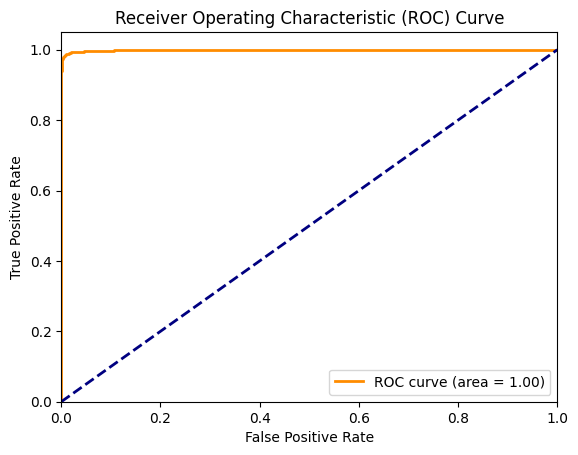

In [10]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1])

roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()